In [ ]:
!pip install fastai2

In [ ]:
!pip install langdetect

In [7]:
from google.cloud import bigquery
from langdetect import detect
from fastai2.text.all import *
from google.colab import auth,drive

In [8]:
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


In [9]:
auth.authenticate_user()

In [10]:
project_id = 'tlac-vision'

client = bigquery.Client(project=project_id)
df = client.query('''
  SELECT
    *
  FROM
    `tlac-vision.book_backend.train_categories`
''').to_dataframe()

In [ ]:
# sorting dataframe by book category, from A to Z
df = df.sort_values(['category'], ascending=True)
# dropping duplicate rows
df = df.drop_duplicates(['title']).reset_index(drop=True)

In [12]:
# deleting results that are in other languages different to spanish
df['language'] = ""
for index, row in df.iterrows():
    row['language'] = detect(row['description'])
df = df[df.language == 'es']

cat_count = df.iloc[:,0:2].groupby('category').count().rename(columns={'title': 'count'})  # total of registers per category

In [13]:
# 75% of data is for training
cat_count['training'] = round(0.75 * cat_count['count'], 0)
# organizing indexes to split data
cat_count['acum'] = cat_count['count'].cumsum()
cat_count['init_idx'] = cat_count['acum'] - cat_count['count']
cat_count['train_idx'] = cat_count['init_idx'] + cat_count['training']

In [14]:
# creating training set with 75% of data per category
train_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 3])
    f_idx = int(cat_count.iloc[i, 4])
    train_set = train_set.append(df.iloc[i_idx:f_idx, :])

train_set_f = train_set.loc[:, ['category', 'description']]
train_set_f['is_valid']=False
train_set_f.iloc[0:5,]

,category,description,is_valid
0,anthropology,"""Después de 60 años como misionero en el Perú y con una admirable trayectoria en sus estudios de antropología amazónica, el P. Ricardo Álvarez Lobo presenta esta gran obra en la que se evocan los momentos más importantes de su vida, al tiempo que ofrece diversos ensayos antropológicos derivados de su trabajo misionero con poblaciones indígenas en el Bajo Urubamba. La presencia misionera de la orden dominicana en la Amazonía peruana ha estado marcada desde inicios del siglo XX por el testimonio de grandes misioneros y su compromiso permanente con las poblaciones nativas. Los escritos del P....",False
1,anthropology,"A lo largo de los últimos cien años la antropología ha realizado contribuciones fundamentales a la comprensión del mundo. No obstante, no tenía una guía de referencia breve y de fácil acceso que proporcionara información sobre temas de importancia, conceptos significativos, metodologías y teorías, junto con una guía bibliográfica clave. Este diccionario se concentra en temas de antropología cultural y social, pero también incluye aspectos relacionados de arqueología, antropología física y ling ̧ística. No intenta establecer o definir los límites de un vocabulario canónico, pero busca los e...",False
2,anthropology,"En este libro, uno de los principales teoricos sociales de la actualidad acomete el tema que mas ha fascinado a los cientificos sociales durante los ultimos anos: la cultura. Bauman pretende clasificar los significados de la cultura distinguiendo entre la cultura como concepto, la cultura como estructura y la cultura como praxis. Analiza, por consiguiente, las diferentes formas en que se utiliza en cada uno de dichos ambitos. Enfrentado al enfoque relativista, Bauman recela de aquellos tratamientos que abordan la cultura en forma de reportajes. Para Bauman, se trata de un aspecto vivo y ca...",False
3,anthropology,"El fuego, presente ya en los inicios del proceso de hominización, fue motivo privilegiado de ritos solsticiales, profilácticos, comunitarios, etc. en todo tipo de sociedades y asimismo estuvo íntimamente unido a las conquistas civilizatorias, fuesen la agricultura o la máquina de vapor. En este volumen, el fuego es objeto de reflexión por parte de dieciocho expertos procedentes preferentemente del campo de la antropología social y con aportaciones de la mitografía, la historia del arte y la ecología.",False
4,anthropology,"Este ambicioso tratado sobre el fenómeno religioso en América Latina es producto de una larga docencia universitaria y de investigaciones realizadas sobre el terreno en varios países. Aunque su enfoque es básicamente antropológico, incluye también una dimensión interdisciplinar y pretende ser útil a todos los estudiosos del hecho religioso. Consta de dos partes independientes. La primera es un análisis general del fenómeno religioso, en el que se exponen conceptos y teorías sobre el mismo: la religión y su especificidad, mito y rito, experiencia y éxtasis, ética y política, sincretismo, se...",False


In [15]:
# creating validation set with 25% of data per category
val_set = pd.DataFrame(data=None, columns=df.columns)
for i in range(len(cat_count)):
    i_idx = int(cat_count.iloc[i, 4])
    f_idx = int(cat_count.iloc[i, 2])
    val_set = val_set.append(df.iloc[i_idx:f_idx, :])

val_set_f = val_set.loc[:, ['category', 'description']]
val_set_f['is_valid']=True
val_set_f.iloc[0:5,]

,category,description,is_valid
85,anthropology,"Antología preparada en torno al axolote (o axólotl o ajolote), criatura casi mítica de Mesoamérica, presente en la obra plástica y escrita, desde los códices mesoamericanos hasta en las páginas de autores como Cortázar y Satoshi Tajiri. la antología reúne textos de Juan José Arreola (El ajolote) Primo Levi (Mariposa angelical), José Emilo pacheco (El reposo del fuego), Julio Cortázar (Axólotl), Octavio Paz (Salamandra) entre otros, y obra plástica, desde graffiti callejero hasta pintura de Diego Rivera o José María Velasco.",True
86,anthropology,"Sirviéndose de los recursos metodológicos propios de la disciplina y poniendo de manifiesto su deuda con el pensamiento filosófico, «Las raíces filosóficas de la antropología» se sumerge en la prehistoria de la antropología. Al igual que la mayor parte de los antropólogos, William Adams, catedrático emérito de antropología de la Universidad de Kentucky. considera que las raíces intelectuales de la disciplina tienen su origen en la filosofía moral ilustrada o, como mucho, en el humanismo renacentista. Sin embargo, en esta obra Adams pone de manifiesto que buena parte de las principales idea...",True
87,anthropology,"Este trabajo consta de dos partes bien diferenciadas. En la primera, se elabora y define un modelo de institucionalización que pueda facilitar la comprensión de otros procesos cuyos elementos no se nos presentan tan claramente definidos. La segunda parte es una búsqueda de aquellos elementos que condujeron a la institucionalización de la antropología como disciplina científica, tras ser objeto de intensos y ruidosos debates cuyo análisis constituye la parte central del trabajo. Índice: Sobre la historia de la antropología en Cataluña, por C. Esteva Fabregat.- Presentación.- La antropología...",True
88,anthropology,"Los problemas de la bioética no solo son, en la actualidad, una preocupación universitaria. Se debaten en ámbitos muy dispares. Están en boca de los políticos, cuando tratan de regular la fecundación artificial, de los médicos, cuando se enfren-tan ante un caso de trasplante de órganos o de eu-tanasia, y de cualquier persona que se sienta interpelado por el valor de la vida humana y de su defensa. Nadie está hoy a margen de las discusiones en este campo. Y son muchos los conflictos que se generan. Este libro ofrece al lector un profundo estudio de los problemas bioéticos partiendo de la id...",True
89,anthropology,"La ANTROPOLOGÍA kantiana, más que en la diversidad y relatividad de las culturas, se centra en los rasgos específicos de la especie humana, si bien para «ensanchar el volumen de la antropología» se recomiende viajar o al menos leer libros de viajes y prestar atención a las obras literarias y a las biografías, pues aunque en ellas la ficción invente y acuse ciertos rasgos, vienen a ser un extracto de la observación de lo que los hombres hacen debido a personas de inteligencia penetrante. En la primera parte se estudian sucesivamente las facultades intelectuales, conocimiento y sensibilidad,...",True


In [ ]:
dff = pd.concat([train_set_f, val_set_f]).reset_index(drop=True)

In [17]:
count2=round(dff.iloc[:,1:3].groupby('is_valid').count().rename(columns={'description': '%'})/2478,3)
count2

,%
is_valid,
False,0.749
True,0.250


In [18]:
dsets = pickle.load(open(f'/content/drive/My Drive/Colab Notebooks/TLAC/dsets.pkl','rb'))

In [19]:
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/wiki_art_tok.zip"

In [20]:
!mv "/content/content/wiki_art_tok" "/content/"

In [21]:
bs,sl=32,80
dbunch_lm = dsets.dataloaders(bs=bs, seq_len=sl, val_bs=bs)

In [22]:
%%capture
!unzip -q "/content/drive/My Drive/Colab Notebooks/TLAC/models.zip"

In [23]:
!mv "/content/content/models" "/content/"

In [34]:
opt_func = partial(Adam, wd=0.1)
learn = language_model_learner(dbunch_lm, AWD_LSTM, opt_func=opt_func, metrics=accuracy)
learn = learn.to_fp16(clip=0.1)

In [35]:
bc_clas = DataBlock(blocks=(TextBlock.from_df('description', seq_len=sl, vocab=dbunch_lm.vocab), CategoryBlock),
                      get_x=ColReader('text'),
                      get_y=ColReader('category'),
                      splitter=ColSplitter('is_valid'))

In [36]:
dbunch_clas = bc_clas.dataloaders(dff, bs=bs)

In [ ]:
dbunch_clas.show_batch()

In [38]:
learn.load('wm1')

In [39]:
learn.save_encoder('enc1')

In [47]:
learn2 = text_classifier_learner(dbunch_clas, AWD_LSTM, drop_mult=0.01, metrics=accuracy).to_fp16()
learn2.load_encoder('enc1')

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.007585775572806597)

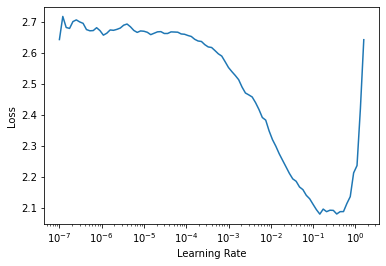

In [48]:
learn2.lr_find()

In [56]:
learn2.fit_one_cycle(3, 2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.641876,4.555510,0.253226,00:07
1,1.232447,1.781625,0.508065,00:07
2,0.728011,1.745612,0.530645,00:07


In [51]:
learn2.predict("""Tras otro abominable verano con los Dursley, Harry se dispone a iniciar
el cuarto curso en Hogwarts, la famosa escuela de magia y hechicería. A
sus catorce años, a Harry le gustaría ser un joven mago como los demás
y dedicarse a aprender nuevos sortilegios, encontrarse con sus amigos
Ron y Hermione y asistir con ellos a los Mundiales de quidditch. Sin
embargo, al llegar al colegio le espera una gran sorpresa que lo obligará
a enfrentarse a los desafíos más temibles de toda su vida. Si logra
superarlos, habrá demostrado que ya no es un niño y que está preparado
para vivir las nuevas y emocionantes experiencias que el futuro le
depara.""")

('education',
 tensor(3),
 tensor([5.6451e-06, 1.5729e-03, 5.8303e-04, 6.9896e-01, 1.2449e-06, 1.7399e-04,
         7.5431e-04, 2.7849e-03, 2.9480e-01, 3.6265e-04, 4.9326e-07]))